# 決定木のアンサンブル法<br>

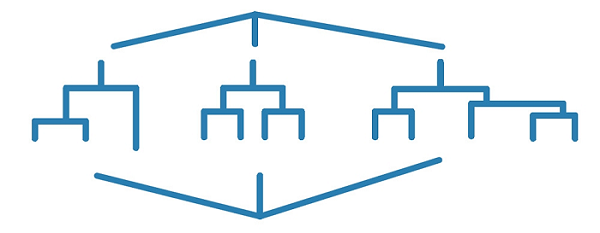

### 目的

決定木・ランダムフォレスト・勾配ブースティングにおける、精度と特徴量選択を比較し理解する。<br>
<br>

### データの準備

今回はTitanic（Kaggle）のデータを使用します。

・https://www.kaggle.com/c/titanic

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import optuna
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('train:',train.shape)
print('test:',test.shape)

train: (891, 12)
test: (418, 11)


In [3]:
y = train['Survived']
train = train[[col for col in train.columns if col != 'Survived']]
PassengerId = test['PassengerId']

print('train:',train.shape)
print('test:',test.shape)

train: (891, 11)
test: (418, 11)


In [4]:
X = pd.concat([train, test], axis=0)

print('X:',X.shape)
X.head()

X: (1309, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


・Survived：生存したかどうか（0：助からない、1：助かる）

・PassengerId：乗客ID<br>
・Pclass – チケットのクラス（1：上層クラス、2：中級クラス、3：下層クラス）<br>
・Name：乗客の名前<br>
・Sex：性別<br>
・Age：年齢<br>
・SibSp：船に同乗している兄弟・配偶者の数<br>
・parch：船に同乗している親・子供の数<br>
・ticket：チケット番号<br>
・fare：料金<br>
・cabin：客室番号<br>
・Embarked：船に乗った港（C：Cherbourg、Q：Queenstown、S：Southampton）

In [5]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = X[features]

X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


後ほど各モデルにおける、特徴量の重要度を比較するため、今回はOne-Hot-Encodingではない前処理をします。

In [6]:
def code_transform(x):
    if x == 'male':
        y = 0
    else:
        y = 1
    return y

X['Sex'] = X['Sex'].apply(lambda x: code_transform(x))

In [7]:
X['Embarked'] = X['Embarked'].fillna(value='missing')

def code_transform(x):
    if x == 'S':
        y = 0       
    elif x == 'C':
        y = 1  
    elif x == 'Q':
        y = 2      
    else:
        y = 3

    return y

X['Embarked'] = X['Embarked'].apply(lambda x: code_transform(x))

In [8]:
X['Age'] = X['Age'].fillna(X['Age'].median())
X['Fare'] = X['Fare'].fillna(X['Fare'].median())

print(X.dtypes)
print('Total null:',X.isnull().sum().sum())
X.head()

Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked      int64
dtype: object
Total null: 0


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.0,1,0,7.2500,0
1,1,1,38.0,1,0,71.2833,1
2,3,1,26.0,0,0,7.9250,0
3,1,1,35.0,1,0,53.1000,0
4,3,0,35.0,0,0,8.0500,0


In [9]:
train_rows = train.shape[0]
X = X[:train_rows]

print('X:', X.shape)
print('y:', y.shape)

X: (891, 7)
y: (891,)


決定木では個々の特徴量は独立に処理され、データの分割はスケールに依存しないため、正規化や標準化は不要である。

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train.head()

X_train: (712, 7)
y_train: (712,)
X_test: (179, 7)
y_test: (179,)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
140,3,1,28.0,0,2,15.2458,1
439,2,0,31.0,0,0,10.5000,0
817,2,0,31.0,1,1,37.0042,1
378,3,0,20.0,0,0,4.0125,1
491,3,0,21.0,0,0,7.2500,0


※今回の発表で重要視するのは、モデルの精度ではなく、どのモデルでも対応できるデータの前処理ですので、ご了承下さい。

### 1. 決定木

In [11]:
tree = DecisionTreeClassifier(max_depth = 4, random_state=0)
tree.fit(X_train, y_train)

print('Accuracy on training set: {:.3f}'.format(tree.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(tree.score(X_test, y_test)))

Accuracy on training set: 0.843
Accuracy on test set: 0.816


In [12]:
tree = DecisionTreeClassifier(max_depth = 5, random_state=0)
tree.fit(X_train, y_train)

print('Accuracy on training set: {:.3f}'.format(tree.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(tree.score(X_test, y_test)))

Accuracy on training set: 0.850
Accuracy on test set: 0.816


In [13]:
tree = DecisionTreeClassifier(max_depth = 6, random_state=0)
tree.fit(X_train, y_train)

print('Accuracy on training set: {:.3f}'.format(tree.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(tree.score(X_test, y_test)))

Accuracy on training set: 0.872
Accuracy on test set: 0.827


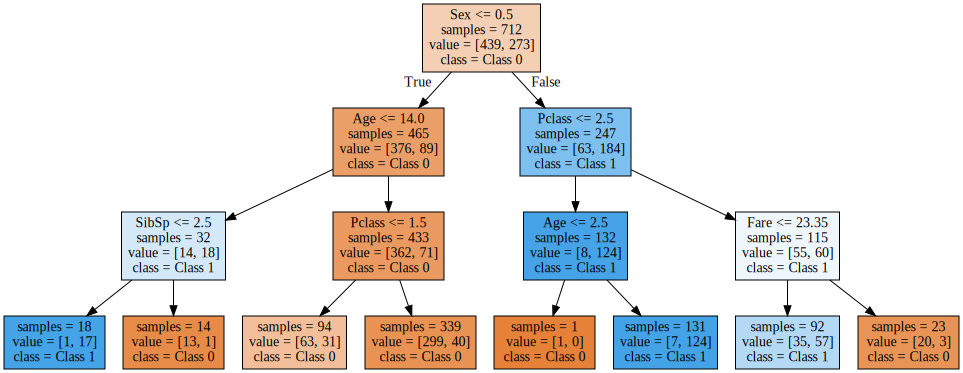

In [14]:
tree = DecisionTreeClassifier(max_depth = 3, random_state=0)
tree.fit(X_train, y_train)

export_graphviz(tree, out_file="tree.dot", class_names=["Class 0", "Class 1"],
                feature_names=features, impurity=False, filled=True)

with open('tree.dot') as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

graphvizはインストールとパスを通す必要があるため、そうでないプロット方法も示しておきます。

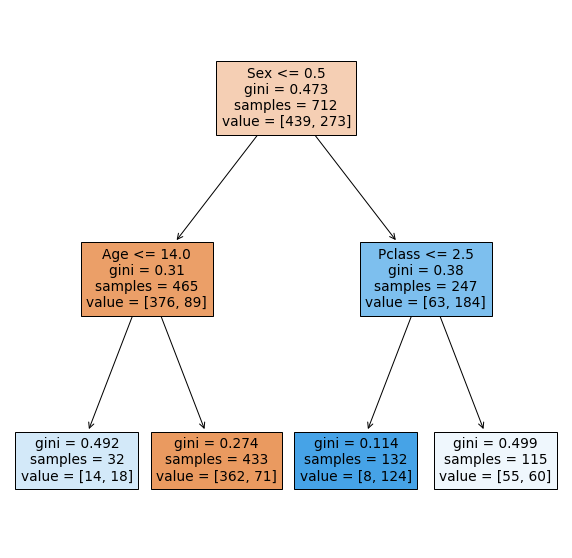

In [15]:
tree = DecisionTreeClassifier(max_depth = 2, random_state=0)
tree.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(10, 10))
plot_tree(tree, feature_names=features, filled=True)
plt.show()

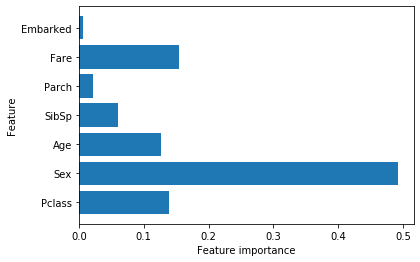

In [16]:
tree = DecisionTreeClassifier(max_depth = 6, random_state=0)
tree.fit(X_train, y_train)

def plot_feature_importances_cancer(model):
    n_features = len(features)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), features)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances_cancer(tree)

### 2. ランダムフォレスト

In [17]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(X_train, y_train)

print('Accuracy on training set: {:.3f}'.format(forest.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(forest.score(X_test, y_test)))

Accuracy on training set: 0.961
Accuracy on test set: 0.821


In [18]:
forest = RandomForestClassifier(n_estimators=7, random_state=0)
forest.fit(X_train, y_train)

print('Accuracy on training set: {:.3f}'.format(forest.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(forest.score(X_test, y_test)))

Accuracy on training set: 0.963
Accuracy on test set: 0.832


In [19]:
%%time

forest = RandomForestClassifier(n_estimators=10, random_state=0)
forest.fit(X_train, y_train)

print('Accuracy on training set: {:.3f}'.format(forest.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(forest.score(X_test, y_test)))

Accuracy on training set: 0.963
Accuracy on test set: 0.844
Wall time: 256 ms


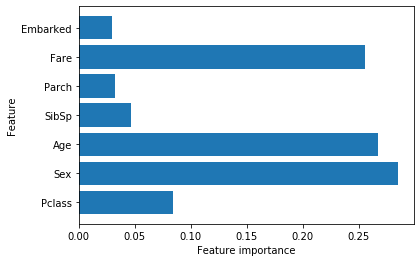

In [20]:
plot_feature_importances_cancer(forest)

### 3. 勾配ブースティング（Gradient Boosting）

In [21]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1, learning_rate=0.7)
gbrt.fit(X_train, y_train)

print('Training set score: {:.3f}'.format(gbrt.score(X_train, y_train)))
print('Test set score: {:.3f}'.format(gbrt.score(X_test, y_test)))

Training set score: 0.853
Test set score: 0.832


In [22]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1, learning_rate=0.1)
gbrt.fit(X_train, y_train)

print('Accuracy Training set score: {:.3f}'.format(gbrt.score(X_train, y_train)))
print('Accuracy Test set score: {:.3f}'.format(gbrt.score(X_test, y_test)))

Accuracy Training set score: 0.819
Accuracy Test set score: 0.804


In [23]:
%%time

gbrt = GradientBoostingClassifier(random_state=0, max_depth=3, learning_rate=0.1)
gbrt.fit(X_train, y_train)

print('Accuracy Training set score: {:.3f}'.format(gbrt.score(X_train, y_train)))
print('Accuracy Test set score: {:.3f}'.format(gbrt.score(X_test, y_test)))

Accuracy Training set score: 0.900
Accuracy Test set score: 0.855
Wall time: 436 ms


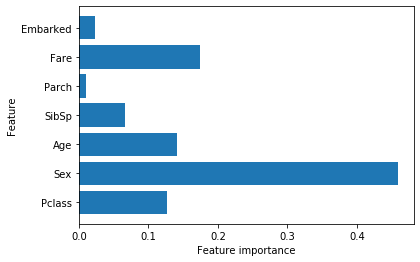

In [24]:
plot_feature_importances_cancer(gbrt)

実用的な勾配ブースティングモデルについても、いくつか見ておきます。（軽く触れる程度とします）

### 4. XGBoost（eXtreme Gradient Boosting）

・データとの相性が良ければ、精度が高くなりやすい<br>
・計算に時間がかかる<br>
・パラメータ調整が適切でないと、過学習が起こりやすい

In [25]:
# optuna
params = {'n_estimators': 187, 'max_depth': 6, 'learning_rate': 0.2}

cls = xgb.XGBClassifier(**params)
cls.fit(X_train, y_train)

print('Training set score: {:.3f}'.format(cls.score(X_train, y_train)))
print('Test set score: {:.3f}'.format(cls.score(X_test, y_test)))

Training set score: 0.969
Test set score: 0.860


In [26]:
%%time

# optuna
params = {'max_bin': 427, 'n_estimators': 105}
          
cls = xgb.XGBClassifier(**params)
cls.fit(X_train, y_train)

print('Training set score: {:.3f}'.format(cls.score(X_train, y_train)))
print('Test set score: {:.3f}'.format(cls.score(X_test, y_test)))

Training set score: 0.966
Test set score: 0.866
Wall time: 366 ms


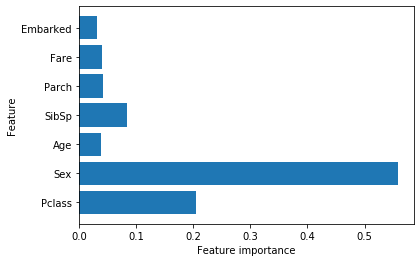

In [27]:
plot_feature_importances_cancer(cls)

### 5. LightGBM（Light Grandient Boosting Model）

・カテゴリカル変数をそのまま使用できる<br>
・計算時間を短縮できる<br>
・パラメータ調整が適切でないと、過学習が起こりやすい

In [28]:
# optuna
params = {'num_leaves': 10, 'n_estimators': 113, 'max_depth': 8, 'learning_rate': 0.05}

cls = lgb.LGBMClassifier(**params)
cls.fit(X_train, y_train)

print('Training set score: {:.3f}'.format(cls.score(X_train, y_train)))
print('Test set score: {:.3f}'.format(cls.score(X_test, y_test)))

Training set score: 0.881
Test set score: 0.849


In [29]:
%%time

# optuna
params = {'max_bin': 427, 'num_leaves': 100}
    
cls = lgb.LGBMClassifier(**params)
cls.fit(X_train, y_train)

print('Training set score: {:.3f}'.format(cls.score(X_train, y_train)))
print('Test set score: {:.3f}'.format(cls.score(X_test, y_test)))

Training set score: 0.944
Test set score: 0.855
Wall time: 231 ms


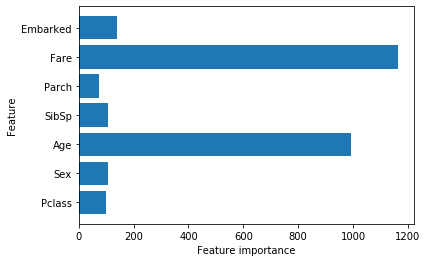

In [30]:
plot_feature_importances_cancer(cls)

※LightGBMは、今回のように数値変換してしまうより、カテゴリカル変数をそのまま使用した方が、精度が高くなる可能性がある。

### 6. CatBoost（Category Boosting）

・カテゴリカル変数を扱いやすい<br>
・計算に時間がかかる<br>
・パラメータ調整が適切でないと、過学習が起こりやすい<br>

In [31]:
# optuna
params = {'n_estimators': 136, 'max_depth': 3, 'learning_rate': 0.62}

cls = CatBoostClassifier(**params)
cls.fit(X_train, y_train)

0:	learn: 0.5121904	total: 194ms	remaining: 26.2s
1:	learn: 0.4743104	total: 198ms	remaining: 13.2s
2:	learn: 0.4444765	total: 200ms	remaining: 8.85s
3:	learn: 0.4254633	total: 207ms	remaining: 6.83s
4:	learn: 0.4175372	total: 209ms	remaining: 5.47s
5:	learn: 0.4121246	total: 210ms	remaining: 4.56s
6:	learn: 0.4060387	total: 212ms	remaining: 3.9s
7:	learn: 0.4016509	total: 213ms	remaining: 3.41s
8:	learn: 0.4008569	total: 214ms	remaining: 3.02s
9:	learn: 0.3994919	total: 216ms	remaining: 2.72s
10:	learn: 0.3959648	total: 217ms	remaining: 2.47s
11:	learn: 0.3935381	total: 220ms	remaining: 2.27s
12:	learn: 0.3927453	total: 226ms	remaining: 2.13s
13:	learn: 0.3910029	total: 227ms	remaining: 1.98s
14:	learn: 0.3902787	total: 229ms	remaining: 1.84s
15:	learn: 0.3899352	total: 230ms	remaining: 1.73s
16:	learn: 0.3882807	total: 231ms	remaining: 1.62s
17:	learn: 0.3879221	total: 232ms	remaining: 1.52s
18:	learn: 0.3877781	total: 234ms	remaining: 1.44s
19:	learn: 0.3867544	total: 235ms	remainin

In [32]:
print('Training set score: {:.3f}'.format(cls.score(X_train, y_train)))
print('Test set score: {:.3f}'.format(cls.score(X_test, y_test)))

Training set score: 0.910
Test set score: 0.838


In [33]:
%%time

# optuna
params = {'depth' : 6, 'learning_rate' : 0.16, 'early_stopping_rounds' : 10, 'iterations' : 200,}

cls = CatBoostClassifier(**params)
cls.fit(X_train, y_train)

0:	learn: 0.5995943	total: 5.6ms	remaining: 1.11s
1:	learn: 0.5313538	total: 11.5ms	remaining: 1.14s
2:	learn: 0.4912635	total: 16.6ms	remaining: 1.09s
3:	learn: 0.4623213	total: 27.5ms	remaining: 1.35s
4:	learn: 0.4526194	total: 29.4ms	remaining: 1.15s
5:	learn: 0.4459267	total: 32ms	remaining: 1.04s
6:	learn: 0.4411898	total: 34.8ms	remaining: 960ms
7:	learn: 0.4322463	total: 41.4ms	remaining: 993ms
8:	learn: 0.4257809	total: 44.7ms	remaining: 948ms
9:	learn: 0.4141261	total: 48.4ms	remaining: 920ms
10:	learn: 0.4074414	total: 50.9ms	remaining: 874ms
11:	learn: 0.4020056	total: 60ms	remaining: 941ms
12:	learn: 0.3993023	total: 65ms	remaining: 934ms
13:	learn: 0.3930204	total: 69.3ms	remaining: 921ms
14:	learn: 0.3888778	total: 73.4ms	remaining: 906ms
15:	learn: 0.3848247	total: 79.6ms	remaining: 915ms
16:	learn: 0.3818055	total: 87.2ms	remaining: 939ms
17:	learn: 0.3789712	total: 90.5ms	remaining: 915ms
18:	learn: 0.3736283	total: 93.9ms	remaining: 894ms
19:	learn: 0.3703937	total: 9

160:	learn: 0.1558426	total: 763ms	remaining: 185ms
161:	learn: 0.1553818	total: 777ms	remaining: 182ms
162:	learn: 0.1542626	total: 786ms	remaining: 178ms
163:	learn: 0.1520262	total: 790ms	remaining: 174ms
164:	learn: 0.1513527	total: 795ms	remaining: 169ms
165:	learn: 0.1504942	total: 798ms	remaining: 163ms
166:	learn: 0.1498799	total: 801ms	remaining: 158ms
167:	learn: 0.1491385	total: 805ms	remaining: 153ms
168:	learn: 0.1482310	total: 807ms	remaining: 148ms
169:	learn: 0.1469515	total: 810ms	remaining: 143ms
170:	learn: 0.1464978	total: 813ms	remaining: 138ms
171:	learn: 0.1462846	total: 816ms	remaining: 133ms
172:	learn: 0.1453916	total: 823ms	remaining: 128ms
173:	learn: 0.1442154	total: 828ms	remaining: 124ms
174:	learn: 0.1434867	total: 834ms	remaining: 119ms
175:	learn: 0.1431237	total: 837ms	remaining: 114ms
176:	learn: 0.1418507	total: 841ms	remaining: 109ms
177:	learn: 0.1410011	total: 844ms	remaining: 104ms
178:	learn: 0.1405638	total: 849ms	remaining: 99.6ms
179:	learn:

Wall time: 1.81 s

In [34]:
print('Training set score: {:.3f}'.format(cls.score(X_train, y_train)))
print('Test set score: {:.3f}'.format(cls.score(X_test, y_test)))

Training set score: 0.969
Test set score: 0.849


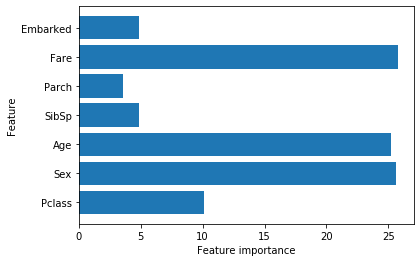

In [35]:
plot_feature_importances_cancer(cls)

### 考察

今回のTitanicデータにおいて、シングルやブースティングよりも<br>
ランダムフォレストの方が、多くの特徴量を重要視していることが考えられる。

精度については、データとの相性や適切なパラメータの調整ができれば、勾配ブースティングの方が高くなりやすい。<br>
ただし、ランダムフォレストでも、ある程度の精度は担保できており、時間も比較的かからないため、使いやすいというメリットがある。

また、カテゴリカル変数を含むデータや、Kaggleのように最後の1%のまで性能を絞り出す場合には、勾配ブースティングが向いている。

### 結論

決定木を用いたモデリングをする際は、まずランダムフォレストを試してから、勾配ブースティングを試してみると良い。<br>
<br>

### 参考文献

・[Pythonではじめる機械学習](https://www.oreilly.co.jp/books/9784873117980/)<br>
・[LightGBM 徹底入門](https://www.codexa.net/lightgbm-beginner/)<br>
・[XGBoost論文を丁寧に解説する](https://qiita.com/triwave33/items/aad60f25485a4595b5c8)<br>
・[Catboostとは？](https://toukei-lab.com/catboost)<br>
・[CatBoostの解説](https://data-analysis-stats.jp/python/python%E3%81%A7catboost%E3%81%AE%E8%A7%A3%E8%AA%AC/)<br>
・[XGBoost・LightGBM・CatBoostの違い](https://logmi.jp/tech/articles/322734)<br>